In [1]:
import numpy as np
import os
from collections import Counter
import json

In [2]:
def getLexOrText(d):
    if not d['analysis']:
        return d['text'].lower()
    
    analysis = d['analysis'][0]
    
    return analysis['lex'] if 'lex' in analysis else d['text'].lower()

`analyze_file` возвращает лист слов в нижнем регистре. Если mystem справился с анализом слова, оно заменяется леммой. Этого может не произойти, если, например, слово написано латиницей; в таком случае вернется исходная форма слова.

In [3]:
from subprocess import check_output
def analyze_file(file):
    words_results = check_output(['mystem', '-n', '--format', 'json', file]).decode().split('\n')
    words_results = filter(bool, words_results)
    json_results = [json.loads(w) for w in words_results]
    
    result = list(map(getLexOrText, json_results))
    return result

Функция ниже работает ~2,5 часа. Она записывает в файл данные о коллекции слов в формате:

word x y

где x - сколько раз встретилось слово word (или его формы), y - в скольких документах оно (или его формы) встретилось

In [ ]:
def get_collection(text_dir):
    collection = Counter()
    collection_doc = Counter()

    #cnt = 0
    for filename in os.listdir(text_dir):
        if not filename.endswith(".txt"):
            continue
    
        #cnt += 1
        #if cnt % 200 == 0:
            #print(cnt)
            
        with open(text_dir + filename) as f:
            words = analyze_file(text_dir + filename)
            collection.update(words)
            collection_doc.update(set(words))
        
    # save file
    
    with open(OUTPUT_COLLECTION_FILE, 'a') as out:
        for value, count in collection.items():
            s = value + ' ' + str(count) + ' ' + str(collection_doc[value])
            out.write(s + os.linesep)

In [ ]:
get_collection(TEXT_DIR_TOTAL, OUTPUT_COLLECTION_FILE)

Анализируем только русские стоп-слова. Их мало, поэтому можем хранить их.

In [4]:
stop_words = []
def get_stop_words(file):
    if stop_words:
        return
    
    with open(file) as f:
        for word in f:
            stop_words.append(word.split()[0])

In [5]:
get_stop_words('../outputDir/russian')

In [6]:
TEXT_DIR_TOTAL = '../outputDir/text/'
OUTPUT_COLLECTION_FILE = '../outputDir/collection'

In [7]:
def get_num_of_stop_words(words):
    stop_w = list(filter(lambda w: w[0] in stop_words, words))
    return sum(list(map(lambda w: w[1], stop_w)))

In [8]:
import re
latin_word = re.compile(r'[a-z]+')
def is_word_latin(w):
    word = w[0]
    return latin_word.search(word) is not None

def get_num_of_latin_words(words):
    res = [0, 0]
    for w in words:
        if is_word_latin(w):
            res[0] += 1
            res[1] += w[1]

    return res

In [9]:
def get_word_length(words):
    res = [0, 0]
    for w in words:
        res[0] += len(w[0])
        res[1] += len(w[0]) * w[1]
        
    return res

In [10]:
def get_words_cf(words, total_words_in_collection, stop=False):
    def word_to_cf(w):
        return [w[0], w[1] / total_words_in_collection]

    res = list(map(word_to_cf, words))
    res.sort(key=lambda el: -el[1])
    if stop:
        res = list(filter(lambda w: w[0] not in stop_words, res))
    return res

In [11]:
def get_words_idf(words, total_docs, stop=False):
    def word_to_idf(w):
        return [w[0], total_docs / w[2]]

    res = list(map(word_to_idf, words))
    res.sort(key=lambda el: el[1])
    if stop:
        res = list(filter(lambda w: w[0] not in stop_words, res))
    return res

In [12]:
def line_to_list(s):
    l = s.split()
    l[1] = int(l[1])
    l[2] = int(l[2])
    return l

words = []
def read_words(collection_file):
    global words
    if not words:
        with open(collection_file) as f:
            words = list(map(line_to_list, f.readlines()))

In [13]:
from matplotlib import pyplot as plt
from math import log10

def plot_cf(words_cf):
    plt.title("Зависимость ранга от cf", fontweight = 'bold', fontsize = 18)
    plt.xlabel("log(cf)")
    plt.ylabel("log(rank)")
    
    data = np.array([[log10(w[1]), log10(i)] for i, w in enumerate(words_cf, 1)])
    plt.plot(data[:, 0], data[:, 1])
    plt.show()

def plot_idf(words_idf):
    plt.title("Зависимость ранга от idf", fontweight = 'bold', fontsize = 18)
    plt.xlabel("log(idf)")
    plt.ylabel("log(rank)")
    
    data = np.array([[log10(w[1]), log10(i)] for i, w in enumerate(words_idf, 1)])
    plt.plot(data[:, 0], data[:, 1])
    plt.show()


def build_plots(words_cf, words_idf):
    plot_cf(words_cf)
    plot_idf(words_idf)

In [16]:
def get_characteristics(collection_file):
    read_words(collection_file)
    
    total_words_in_collection = sum(map(lambda w: w[1], words))
    words_in_dict = len(words)
    print('Всего слов в документах:', total_words_in_collection)
    print('Слов в словаре:', words_in_dict)
    
    print()
    
    num_of_stop_words = get_num_of_stop_words(words)
    print('Стоп-слов в документах:', num_of_stop_words)
    print('Доля стоп-слов:', num_of_stop_words / total_words_in_collection)
    
    print()
    
    num_of_latin_words = get_num_of_latin_words(words)
    print('Слов целиком латиницей в словаре:', num_of_latin_words[0])
    print('Доля слов целиком латиницей в словаре:', num_of_latin_words[0] / words_in_dict)
    print('Слов целиком латиницей в документах:', num_of_latin_words[1])
    print('Доля слов целиком латиницей в документах:', num_of_latin_words[1] / total_words_in_collection)
    
    print()
    
    word_len = get_word_length(words)
    print('Средняя длина слова в словаре:', word_len[0] / words_in_dict)
    print('Средняя длина слова в коллекции:', word_len[1] / total_words_in_collection)
    
    print()
    top_len = 10
    print(str(top_len), "самых частых слов в коллекции:")
    words_cf = get_words_cf(words, total_words_in_collection)
    words_cf_top = words_cf[:top_len]
    for w in words_cf_top:
        print(w)
        
    print()
    total_num_of_docs = 200000
    print(str(top_len), "слов с наименьшим idf:")
    words_idf = get_words_idf(words, total_num_of_docs)
    words_idf_top = words_idf[:top_len]
    for w in words_idf_top:
        print(w)
        
    build_plots(words_cf, words_idf)
    
    print()
    print(str(top_len), "самых частых слов в коллекции без стоп-слов:")
    words_cf = get_words_cf(words, total_words_in_collection, True)
    words_cf_top = words_cf[:top_len]
    for w in words_cf_top:
        print(w)
        
    print()
    print(str(top_len), "слов с наименьшим idf без стоп-слов:")
    words_idf = get_words_idf(words, total_num_of_docs, True)
    words_idf_top = words_idf[:top_len]
    for w in words_idf_top:
        print(w)


Всего слов в документах: 153364496
Слов в словаре: 1302360

Стоп-слов в документах: 29330878
Доля стоп-слов: 0.1912494662389136

Слов целиком латиницей в словаре: 527755
Доля слов целиком латиницей в словаре: 0.4052297367855278
Слов целиком латиницей в документах: 27046183
Доля слов целиком латиницей в документах: 0.17635230907680224

Средняя длина слова в словаре: 9.171717497466139
Средняя длина слова в коллекции: 5.775537833736956

10 самых частых слов в коллекции:
['и', 0.02321374954996103]
['в', 0.022076915376815765]
['на', 0.01202572986644836]
['с', 0.009480603646361541]
['не', 0.008071313976084791]
['http', 0.007169429878998853]
['url', 0.006240727319313852]
['для', 0.005823264336225511]
['по', 0.0057902188782989255]
['весь', 0.004677295063128561]

10 слов с наименьшим idf:
['в', 1.1351382030762245]
['и', 1.1735505184159416]
['на', 1.227091731242369]
['с', 1.3423269237222726]
['by', 1.3663442094332405]
['для', 1.4235179398848374]
['по', 1.4331061860028518]
['весь', 1.451168190393

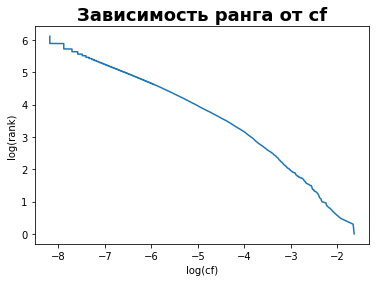

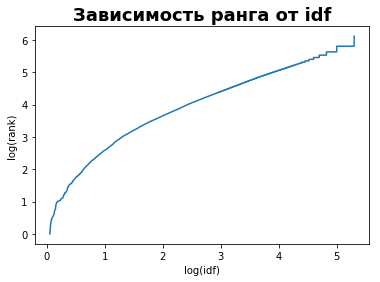


10 самых частых слов в коллекции без стоп-слов:
['http', 0.007169429878998853]
['url', 0.006240727319313852]
['весь', 0.004677295063128561]
['a', 0.004067134286412678]
['www', 0.003973129478415917]
['сообщение', 0.003875271105771443]
['это', 0.0035091824642386592]
['by', 0.0031535330054486667]
['г', 0.002954582134837779]
['год', 0.002846075926203937]

10 слов с наименьшим idf без стоп-слов:
['by', 1.3663442094332405]
['весь', 1.4511681903932665]
['©', 1.480801409722942]
['сайт', 1.7391606810553226]
['главный', 1.8922908072512583]
['новость', 1.966258995634905]
['поиск', 2.056682160338941]
['новый', 2.2646209590669764]
['форум', 2.270663033605813]
['год', 2.2963694399154937]


In [17]:
get_characteristics(OUTPUT_COLLECTION_FILE)